In [1]:
import CodingQuiz1lib as given
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import tqdm

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1465 11818 40808 44541  1368]


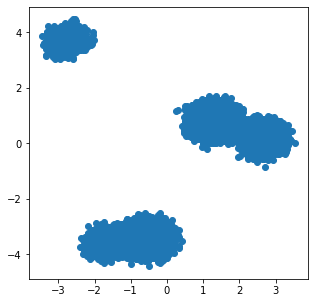

In [2]:
# CREATING THE TARGET DISTRIBUTION ACCORDING TO LIBRARY
ptarget = given.GMM()
samples = ptarget.sample(100000) # to obtain samples
given.plot_samples_2d(samples)

In [3]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
nz = 2
K = 1
epochs = 250

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, h_dim=128, latent_dims=nz):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(2, h_dim)
        self.linear2 = nn.Linear(h_dim, h_dim)
        self.linear3 = nn.Linear(h_dim, latent_dims)
        self.linear4 = nn.Linear(h_dim, latent_dims)

        self.N =  torch.distributions.Normal(0,1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.linear3(x)
        log_var = torch.exp(self.linear4(x))
        z = mu + torch.exp(0.5 * log_var) * self.N.sample(mu.shape)
        self.kl = 0.5*(torch.exp(log_var) + mu**2 - log_var - 1).sum()
        return z, mu, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, h_dim=128, latent_dims=nz):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, h_dim)
        self.linear2 = nn.Linear(h_dim, 2)
    
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        return z

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims=nz):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        return self.decoder(z)

In [7]:
def plot_latent_space(vae, gmm):
    num_samples = 10000
    colors = ["red", "blue", "green", "yellow", "pink"]
    for i in range(len(gmm.components)):
        n = int(gmm.weights[i] * num_samples)
        x = gmm.components[i].sample(S=n)
        plt.figure(0)
        plt.xlim([-4, 4])
        plt.ylim([-5, 5])
        plt.scatter(x[:,0], x[:,1], c=colors[i])
        plt.title("Original data")

        x = torch.from_numpy(x).to(device).float()

        x_hat = vae(x)
        reconstructed = x_hat.cpu().detach()
        plt.figure(1)
        plt.xlim([-4, 4])
        plt.ylim([-5,5 ])
        plt.scatter(reconstructed[:,0], reconstructed[:,1], c=colors[i])
        plt.title("Reconstructed data")

        z, mu, log_var = vae.encoder(x)
        latent_var = mu.cpu().detach()
        plt.figure(2)
        plt.scatter(latent_var[:,0], latent_var[:,1], c=colors[i])
        plt.title("Latent Space")
    plt.show()

In [8]:
vae = VariationalAutoencoder().to(device)
optim_vae = optim.Adam(vae.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.MSELoss()

vae.train()

vae_total_params = sum(p.numel() for p in vae.parameters())

print(vae)
print(vae_total_params)

train_data = torch.from_numpy(samples).to(device).float()
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

losses = []
reconstruction_losses = []
images = []

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=2, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (linear3): Linear(in_features=128, out_features=2, bias=True)
    (linear4): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
  )
)
18054


In [9]:
for epoch in range(epochs):
    loss_r = 0
    loss_total = 0
    for idx, data in enumerate(train_loader):
        x = data.to(device)
        optim_vae.zero_grad()
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl
        # loss = criterion(x, x_hat)
        loss.backward()
        optim_vae.step()
        loss_r += criterion(x, x_hat)
        loss_total += loss
    reconstruction_losses.append(loss_r/idx)
    losses.append(loss_total/idx)
    x_hat = vae(train_data)
    images.append(x_hat.cpu().detach())
    print(f"Epoch {epoch} of {epochs} : Loss = {losses[-1] : .8f} , Reconstruction Loss = {reconstruction_losses[-1] : .8f}")

Epoch 0 of 250 : Loss =  471.68954468 , Reconstruction Loss =  1.22524345
Epoch 1 of 250 : Loss =  384.51925659 , Reconstruction Loss =  0.82834733
Epoch 2 of 250 : Loss =  352.91574097 , Reconstruction Loss =  0.66459316
Epoch 3 of 250 : Loss =  344.24151611 , Reconstruction Loss =  0.62885040
Epoch 4 of 250 : Loss =  341.31369019 , Reconstruction Loss =  0.61474913
Epoch 5 of 250 : Loss =  340.01025391 , Reconstruction Loss =  0.61241984
Epoch 6 of 250 : Loss =  340.57598877 , Reconstruction Loss =  0.61236554
Epoch 7 of 250 : Loss =  341.89541626 , Reconstruction Loss =  0.61241925
Epoch 8 of 250 : Loss =  338.35708618 , Reconstruction Loss =  0.60376847
Epoch 9 of 250 : Loss =  338.14624023 , Reconstruction Loss =  0.60766101
Epoch 10 of 250 : Loss =  339.48959351 , Reconstruction Loss =  0.60728490
Epoch 11 of 250 : Loss =  338.66744995 , Reconstruction Loss =  0.60858613
Epoch 12 of 250 : Loss =  337.91198730 , Reconstruction Loss =  0.60351282
Epoch 13 of 250 : Loss =  337.69741

In [10]:
x_hat = vae(train_data)
x_hat.shape

torch.Size([100000, 2])

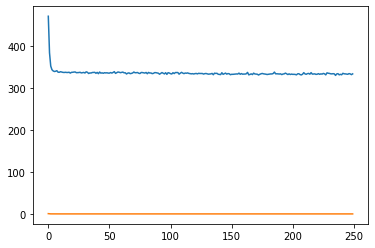

In [11]:
plt.plot(losses)
plt.plot(reconstruction_losses)
plt.show()

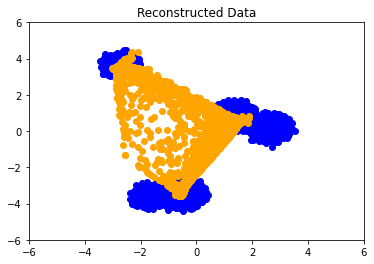

In [15]:
# given.plot_samples_2d(x_hat.cpu().detach())
fig = plt.figure()
ax = plt.axes(xlim=(-6,6), ylim=(-6,6))
plt.title("Reconstructed Data")
plt.scatter(samples[:,0], samples[:,1], c='blue')
plt.scatter(images[-1][:,0], images[-1][:,1], c='orange')

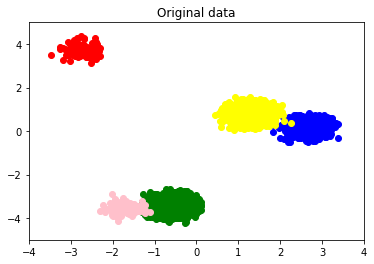

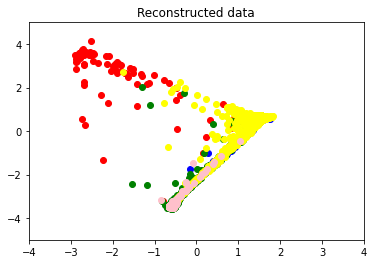

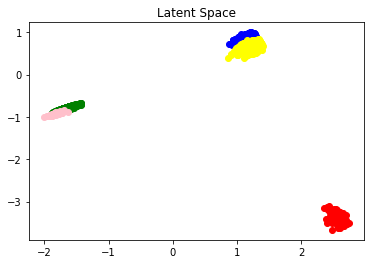

In [14]:
plot_latent_space(vae, ptarget)

In [14]:
for i in range(len(images)):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10,10), ylim=(-10,10))
    plt.scatter(samples[:,0], samples[:,1], c='blue')
    plt.scatter(images[i][:,0], images[i][:,1], c='orange')
    plt.title("Epoch " + str(i))
    plt.savefig('vae_training/epoch_' + str(i) + '.png')
    plt.close()
